# Settings

## Install Packages

In [ ]:
!pip install torch_snippets torch_summary efficientnet_pytorch 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 235 kB 10.8 MB/s 
     |████████████████████████████████| 58 kB 3.0 MB/s 
     |████████████████████████████████| 948 kB 51.8 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=3be5a56a276b0b2c796a7fe6c7dfd17b863d245451bef05ed689a9805d32a982
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=33e4e70022212e70e9048b0983538601db46abd69d47d5a5b019fe854f11c81d
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully buil

## Import Libraries

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch_snippets import *
from torchsummary import summary
from torchvision import transforms as T
from efficientnet_pytorch import EfficientNet

import random
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%cd /content/drive/MyDrive/Govtech/DSAID

random.seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Govtech/DSAID


## Install Data

In [ ]:
!gdown --id 1pWRQbMOCHo1_sBlvXfyxrO89nvNUC3hI
!mkdir data
!unzip 'Assignment 1 - Training Data.zip'
!rm './Assignment 1 - Training Data.zip'
!mv './classes' './data'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pWRQbMOCHo1_sBlvXfyxrO89nvNUC3hI
To: /content/Assignment 1 - Training Data.zip
100% 8.19M/8.19M [00:00<00:00, 52.5MB/s]
Archive:  Assignment 1 - Training Data.zip
  inflating: classes/1003035.jpg     
  inflating: classes/1005343.jpg     
 extracting: classes/1008439.jpg     
  inflating: classes/1015027.jpg     
  inflating: classes/1056555.jpg     
  inflating: classes/1072860.jpg     
  inflating: classes/1079150.jpg     
  inflating: classes/1106366.jpg     
  inflating: classes/1114372.jpg     
  inflating: classes/1126799.jpg     
  inflating: classes/1137948.jpg     
  inflating: classes/1141995.jpg     
  inflating: classes/1179687.jpg     
  inflating: classes/1182765.jpg     
  inflating: classes/1188084

# Data

## Import Data

In [ ]:
data = pd.read_csv('./data/labels.csv')
data.head()

,image,category
0,2788353.jpg,0
1,2782131.jpg,0
2,2884349.jpg,0
3,2900596.jpg,0
4,2841543.jpg,0


In [ ]:
img_mappings = dict(data.values)
ntargets = len(set(img_mappings.values()))
imgs = glob('./data/*jpg')
random.shuffle(imgs)
train_imgs = imgs[100:]
val_imgs = imgs[:100]
print('Number of training data points:', len(train_imgs))
print('Number of validation data points:', len(val_imgs))

Number of training data points: 800
Number of validation data points: 100


## Dataset and Dataloader

In [ ]:
class ShipDataset(Dataset):
    def __init__(self, imgs, img_mappings):
        super().__init__()
        self.imgs = imgs
        self.img_mappings = img_mappings
        self.transforms = T.Compose([ 
            T.Resize((224, 224)),
            T.RandomHorizontalFlip(), 
            T.ToTensor(),
            # standard nomarlization 
            T.Normalize((0.485, 0.456, 0.406), 
                        (0.229, 0.224, 0.225))]
        )

    def __getitem__(self, ind):
        img_path = self.imgs[ind]
        img_file = fname(img_path)
        target = self.img_mappings[img_file]
        # convert from BGR to RGB
        img = Image.open(img_path).convert('RGB')
        return img, target

    def choose(self):
        return self[random.randint(0, len(self)-1)]
    
    def __len__(self):
        return len(self.imgs)

    def collate_fn(self, data):
        imgs, targets = zip(*data)
        imgs = torch.stack([self.transforms(img).float() for img in imgs], 0)
        targets = torch.tensor(targets).long()
        return imgs.to(device), targets.to(device)

**Data Pre-processing**  
- Load and convert image to an RGB image
- Transform the image using the collate_fn to transform in batches thus, reducing the transformation duration. Transformation is as follows:
    1. Resize the input image to 224 as specified by EfficientNet. The smaller edge of the image will be resize to 224.  
    2. Randomly flip some images horizontally.
    3. Convert the image to tensor before normalizing the image to the mean and standard deviation specified by EfficientNet. 

In [ ]:
train_ds = ShipDataset(train_imgs, img_mappings)
train_dl = DataLoader(train_ds, 32, collate_fn=train_ds.collate_fn,
                      drop_last=True)
val_ds = ShipDataset(val_imgs, img_mappings)
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn,
                    drop_last=True)

Target: 2


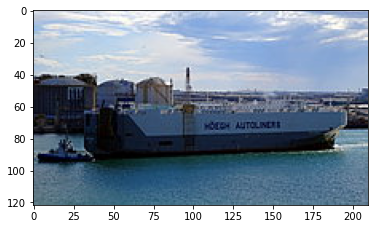

In [ ]:
img, target = train_ds.choose()
print("Target:", target)
plt.imshow(img)
plt.show()

In [ ]:
inspect(*next(iter(train_dl)), names='image,target')

IMAGE:
Tensor	Shape: torch.Size([32, 3, 224, 224])	Min: -2.118	Max: 2.640	Mean: 0.405	dtype: torch.float32 @ cuda:0
TARGET:
Tensor	Shape: torch.Size([32])	Min: 0.000	Max: 4.000	Mean: 2.500	dtype: torch.int64 @ cuda:0


# Model

## Architecture

In [ ]:
class ShipClassifier(nn.Module):
    def __init__(self, ntargets):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b2')
        self.fc = nn.Sequential(
            nn.LayerNorm(1408*7*7),
            nn.Dropout(0.2),
            nn.Linear(1408*7*7, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.2),
            nn.Linear(64, ntargets)
        )
    
    def forward(self, imgs):
        features = self.backbone.extract_features(imgs)
        # flatten
        features = features.reshape(features.size(0), -1)
        return self.fc(features)

In [ ]:
classifer = ShipClassifier(ntargets)
input = torch.zeros(1, 3, 224, 224).to(device)
model_summary = summary(classifer, input)

Loaded pretrained weights for efficientnet-b2
Layer (type:depth-idx)                                  Output Shape              Param #
├─EfficientNet: 1                                       []                        --
|    └─Conv2dStaticSamePadding: 2-1                     [-1, 32, 112, 112]        --
|    |    └─ZeroPad2d: 3-1                              [-1, 3, 225, 225]         --
|    └─BatchNorm2d: 2-2                                 [-1, 32, 112, 112]        64
|    └─MemoryEfficientSwish: 2-3                        [-1, 32, 112, 112]        --
|    └─ModuleList: 2                                    []                        --
|    |    └─MBConvBlock: 3-2                            [-1, 16, 112, 112]        1,448
|    |    └─MBConvBlock: 3-3                            [-1, 16, 112, 112]        612
|    |    └─MBConvBlock: 3-4                            [-1, 24, 56, 56]          6,004
|    |    └─MBConvBlock: 3-5                            [-1, 24, 56, 56]          10,710
|  

# Training

In [ ]:
def train_batch(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    classifier.zero_grad()
    loss.backward()
    optimizer.step()

    # batch accuracy
    preds = outputs.argmax(-1)
    acc = (sum(preds == targets) / len(targets))
    return loss, acc

In [ ]:
@torch.no_grad()
def validate_batch(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)

    # batch accuracy
    preds = outputs.argmax(-1)
    acc = (sum(preds == targets) / len(targets))
    return loss, acc

In [ ]:
epochs = 30
log = Report(epochs)
classifier = ShipClassifier(ntargets).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
max_val_acc = 0

Loaded pretrained weights for efficientnet-b2


**Model Training**
- Loss: **Cross entropy loss** as the target is a prediction of 5 categories.  
- Optimizer: **ADAM** as it uses the best of AdaGrad, momentum to accelerate gradient descent and RMSProp, to minimize vertial steps so as to allow for a larger horizontal step.  
- Learning Rate Scheduler: **StepLR** allows for decreasing learning rate as the number of epoch increases. This allows the model to learn quickly initially due to larger learning rate and learn more optimally at the later stage due to smaller learning rate. 

In [ ]:
for epoch in range(epochs):
    n_train = len(train_dl)
    for i, data in enumerate(train_dl):
        train_loss, train_acc = train_batch(data, classifier, optimizer, loss_fn)
        pos = epoch + ((1+i) / n_train)
        log.record(pos=pos, train_loss=train_loss, train_acc=train_acc, end='\r')
    
    n_val = len(val_dl)
    val_accs = []
    for i, data in enumerate(val_dl):
        val_loss, val_acc = validate_batch(data, classifier, loss_fn)
        pos = epoch + ((1 + i) / n_val)
        log.record(pos=pos, val_loss=val_loss, val_acc=val_acc, end='\r')
        val_accs.append(val_acc.cpu().detach())

    scheduler.step()
    log.report_avgs(epoch+1)
    cur_val_acc = np.mean(val_accs)
    if cur_val_acc > max_val_acc:
        torch.save(classifier.state_dict(), './saved_models/classifier_weights.pth')

EPOCH: 1.000	train_loss: 0.866	train_acc: 0.689	val_loss: 1.132	val_acc: 0.516	(14.33s - 415.51s remaining)
EPOCH: 2.000	train_loss: 0.275	train_acc: 0.916	val_loss: 0.900	val_acc: 0.656	(29.84s - 417.81s remaining)
EPOCH: 3.000	train_loss: 0.145	train_acc: 0.960	val_loss: 0.373	val_acc: 0.865	(42.36s - 381.24s remaining)
EPOCH: 4.000	train_loss: 0.149	train_acc: 0.957	val_loss: 0.288	val_acc: 0.896	(53.96s - 350.72s remaining)
EPOCH: 5.000	train_loss: 0.128	train_acc: 0.962	val_loss: 0.653	val_acc: 0.812	(65.55s - 327.74s remaining)
EPOCH: 6.000	train_loss: 0.082	train_acc: 0.975	val_loss: 0.573	val_acc: 0.844	(77.40s - 309.59s remaining)
EPOCH: 7.000	train_loss: 0.048	train_acc: 0.990	val_loss: 0.669	val_acc: 0.802	(89.08s - 292.68s remaining)
EPOCH: 8.000	train_loss: 0.019	train_acc: 0.998	val_loss: 0.303	val_acc: 0.917	(100.79s - 277.16s remaining)
EPOCH: 9.000	train_loss: 0.021	train_acc: 0.994	val_loss: 0.501	val_acc: 0.885	(112.81s - 263.22s remaining)
EPOCH: 10.000	train_loss: 

100%|██████████| 131/131 [00:00<00:00, 1423.53it/s]


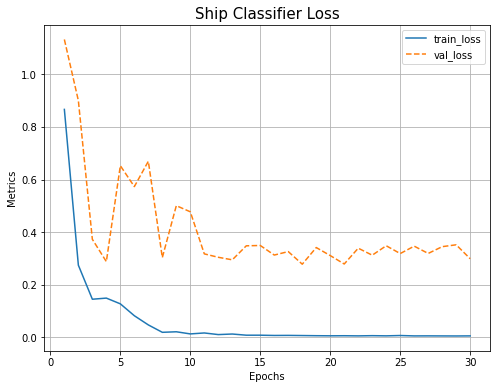

In [ ]:
log.plot_epochs(['train_loss', 'val_loss'], 
                title='Ship Classifier Loss',
                fontdict={'size': 15})

100%|██████████| 131/131 [00:00<00:00, 4431.76it/s]


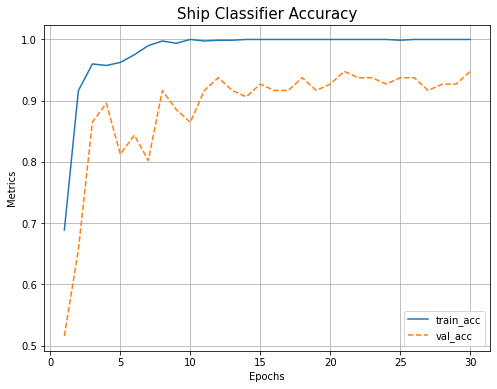

In [ ]:
log.plot_epochs(['train_acc', 'val_acc'], 
                title='Ship Classifier Accuracy',
                fontdict={'size': 15})